<a href="https://colab.research.google.com/github/parth-261204/BMI-Calculator/blob/main/MuscleDystrophy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!pip install nilearn opencv-python scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 42.7 MB/s eta 0:00:00


In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from nilearn.image import resample_to_img
from nilearn import datasets, image, masking


def apply_clahe(np_img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    lab = cv2.cvtColor(np_img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

class MuscularDystrophyDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def preprocess_image(self, img_path):
        img = Image.open(img_path).convert("RGB")
        np_img = np.array(img)

        np_img = apply_clahe(np_img)

        np_img = np_img.astype(np.float32) / 255.0

        img = Image.fromarray((np_img * 255).astype(np.uint8))
        return img

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = self.preprocess_image(img_path)

        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
from collections import defaultdict

# Load all image paths & labels
def load_image_paths(root_dir):
    classes = sorted(os.listdir(os.path.join(root_dir, 'Data')))
    image_paths = []
    labels = []
    for idx, label in enumerate(classes):
        folder_path = os.path.join(root_dir, 'Data', label)
        for file in os.listdir(folder_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                image_paths.append(os.path.join(folder_path, file))
                labels.append(idx)
    return image_paths, labels

image_paths, labels = load_image_paths("./data")

# Stratified split (80-20)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Transform (including resizing, flipping, rotation, normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = MuscularDystrophyDataset(train_paths, train_labels, transform=transform)
val_dataset = MuscularDystrophyDataset(val_paths, val_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)  # 4 classes
model = model.to(device)

torch.save(model.state_dict(), "resnet18_dystrophy_model.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
for epoch in range(10):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    print(f"\n🔁 Starting Epoch {epoch+1}/1")

    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move data to the correct device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        outputs = model(images)
        # Loss computation
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        print(f"  ✅ Batch {batch_idx+1} done | Loss: {loss.item():.4f}")

        # Stop after 3 batches for quick testing (adjust for full training)
        if batch_idx == 2:
            break

    accuracy = 100 * correct / total
    print(f"✅ Epoch [{epoch+1}/1] Completed | Loss: {total_loss:.4f} | Accuracy: {accuracy:.2f}%")



🔁 Starting Epoch 1/1
  ✅ Batch 1 done | Loss: 1.7204
  ✅ Batch 2 done | Loss: 1.6931
  ✅ Batch 3 done | Loss: 1.4959
✅ Epoch [1/1] Completed | Loss: 4.9095 | Accuracy: 16.67%

🔁 Starting Epoch 2/1
  ✅ Batch 1 done | Loss: 1.5173
  ✅ Batch 2 done | Loss: 1.3408
  ✅ Batch 3 done | Loss: 1.1396
✅ Epoch [2/1] Completed | Loss: 3.9977 | Accuracy: 34.38%

🔁 Starting Epoch 3/1
  ✅ Batch 1 done | Loss: 0.9963
  ✅ Batch 2 done | Loss: 1.3736
  ✅ Batch 3 done | Loss: 1.1634
✅ Epoch [3/1] Completed | Loss: 3.5334 | Accuracy: 50.00%

🔁 Starting Epoch 4/1
  ✅ Batch 1 done | Loss: 1.3092
  ✅ Batch 2 done | Loss: 1.1009
  ✅ Batch 3 done | Loss: 0.8042
✅ Epoch [4/1] Completed | Loss: 3.2143 | Accuracy: 59.38%

🔁 Starting Epoch 5/1
  ✅ Batch 1 done | Loss: 0.7832
  ✅ Batch 2 done | Loss: 0.8072
  ✅ Batch 3 done | Loss: 0.8137
✅ Epoch [5/1] Completed | Loss: 2.4041 | Accuracy: 75.00%

🔁 Starting Epoch 6/1
  ✅ Batch 1 done | Loss: 0.5657
  ✅ Batch 2 done | Loss: 0.7577
  ✅ Batch 3 done | Loss: 0.6805
✅ 

In [ ]:
!pip install vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 kB 10.2 MB/s eta 0:00:00


In [ ]:
from vit_pytorch import ViT
import torch.nn as nn

class ViT_CNN_Hybrid(nn.Module):
    def __init__(self, num_classes=4):
        super(ViT_CNN_Hybrid, self).__init__()
        # CNN backbone (ResNet50)
        self.cnn = models.resnet50(pretrained=True)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-2])  # Remove FC and pooling

        # Vision Transformer
        self.vit = ViT(
            image_size=7,       # output from CNN is [B, 2048, 7, 7]
            patch_size=1,
            num_classes=num_classes,
            dim=512,
            depth=6,
            heads=8,
            mlp_dim=1024,
            channels=2048,
            dropout=0.1,
            emb_dropout=0.1
        )

    def forward(self, x):
        x = self.cnn(x)  # [B, 2048, 7, 7]
        x = self.vit(x)
        return x


In [ ]:
import torch

# ✅ Check for GPU availability and print device info
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ GPU detected:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("⚠️ Using CPU — no GPU detected")

# Initialize the ViT-CNN Hybrid model and move it to the selected device
model = ViT_CNN_Hybrid().to(device)

# Define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop for 1 epoch
for epoch in range(1):  # ✅ Only 1 epoch
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    print(f"\n🔁 Starting Epoch {epoch + 1}/1")

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # ✅ Minimal batch log every 10 batches
        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
            print(f"  ✅ Batch {batch_idx + 1}/{len(train_loader)} done...")

    accuracy = 100 * correct / total
    print(f"✅ Epoch [{epoch + 1}/1] Completed | Loss: {total_loss:.4f} | Accuracy: {accuracy:.2f}%")

# ✅ Save the trained model
torch.save(model.state_dict(), "dyst_vit_cnn_hybrid.pth")


✅ GPU detected: Tesla T4


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s]



🔁 Starting Epoch 1/1
  ✅ Batch 10/2161 done...
  ✅ Batch 20/2161 done...
  ✅ Batch 30/2161 done...
  ✅ Batch 40/2161 done...
  ✅ Batch 50/2161 done...
  ✅ Batch 60/2161 done...
  ✅ Batch 70/2161 done...
  ✅ Batch 80/2161 done...
  ✅ Batch 90/2161 done...
  ✅ Batch 100/2161 done...
  ✅ Batch 110/2161 done...
  ✅ Batch 120/2161 done...
  ✅ Batch 130/2161 done...
  ✅ Batch 140/2161 done...
  ✅ Batch 150/2161 done...
  ✅ Batch 160/2161 done...
  ✅ Batch 170/2161 done...
  ✅ Batch 180/2161 done...
  ✅ Batch 190/2161 done...
  ✅ Batch 200/2161 done...
  ✅ Batch 210/2161 done...
  ✅ Batch 220/2161 done...
  ✅ Batch 230/2161 done...
  ✅ Batch 240/2161 done...
  ✅ Batch 250/2161 done...
  ✅ Batch 260/2161 done...
  ✅ Batch 270/2161 done...
  ✅ Batch 280/2161 done...
  ✅ Batch 290/2161 done...
  ✅ Batch 300/2161 done...
  ✅ Batch 310/2161 done...
  ✅ Batch 320/2161 done...
  ✅ Batch 330/2161 done...
  ✅ Batch 340/2161 done...
  ✅ Batch 350/2161 done...
  ✅ Batch 360/2161 done...
  ✅ Batch 370/2

In [ ]:
model.load_state_dict(torch.load("dyst_vit_cnn_hybrid.pth"))
model.eval()

# Evaluation code (e.g., confusion matrix, test set accuracy)

ViT_CNN_Hybrid(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

In [ ]:
!pip install timm


In [ ]:
import timm

# Load Swin Transformer
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=4)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)

# Optional: use learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [ ]:
for epoch in range(10):  # 10 epochs for quick test
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    print(f"\n🌀 Swin Transformer Epoch {epoch+1}/1")

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        print(f"  ✅ Batch {batch_idx+1} done | Loss: {loss.item():.4f}")

        if batch_idx == 2:  # Testing mode
            break

    scheduler.step()
    accuracy = 100 * correct / total
    print(f"✅ Epoch [{epoch+1}/10] Completed | Loss: {total_loss:.4f} | Accuracy: {accuracy:.2f}%")



🌀 Swin Transformer Epoch 1/1
  ✅ Batch 1 done | Loss: 1.3026
  ✅ Batch 2 done | Loss: 1.1328
  ✅ Batch 3 done | Loss: 0.8592
✅ Epoch [1/10] Completed | Loss: 3.2946 | Accuracy: 59.38%

🌀 Swin Transformer Epoch 2/1
  ✅ Batch 1 done | Loss: 0.7069
  ✅ Batch 2 done | Loss: 0.8276
  ✅ Batch 3 done | Loss: 0.8616
✅ Epoch [2/10] Completed | Loss: 2.3960 | Accuracy: 75.00%

🌀 Swin Transformer Epoch 3/1
  ✅ Batch 1 done | Loss: 0.9794
  ✅ Batch 2 done | Loss: 0.5235
  ✅ Batch 3 done | Loss: 0.7228
✅ Epoch [3/10] Completed | Loss: 2.2257 | Accuracy: 76.04%

🌀 Swin Transformer Epoch 4/1
  ✅ Batch 1 done | Loss: 0.7988
  ✅ Batch 2 done | Loss: 0.6267
  ✅ Batch 3 done | Loss: 0.7898
✅ Epoch [4/10] Completed | Loss: 2.2153 | Accuracy: 77.08%

🌀 Swin Transformer Epoch 5/1
  ✅ Batch 1 done | Loss: 0.6914
  ✅ Batch 2 done | Loss: 0.6861
  ✅ Batch 3 done | Loss: 0.7123
✅ Epoch [5/10] Completed | Loss: 2.0899 | Accuracy: 79.17%

🌀 Swin Transformer Epoch 6/1
  ✅ Batch 1 done | Loss: 0.5685
  ✅ Batch 2 d

In [ ]:
# ✅ Save the trained Swin Transformer model
torch.save(model.state_dict(), "dyst_swin_transformer.pth")
print("💾 Swin Transformer model saved as 'dyst_swin_transformer.pth'")


💾 Swin Transformer model saved as 'dyst_swin_transformer.pth'


In [ ]:
import torch
import torch.nn as nn
import timm

class MedViTNet(nn.Module):
    def __init__(self, num_classes=4):
        super(MedViTNet, self).__init__()
        # Base Transformer: DeiT
        self.transformer = timm.create_model('deit_tiny_patch16_224', pretrained=True, num_classes=0)  # No head

        # CNN Branch: basic convolutional features
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((7, 7))
        )

        # Fusion + Classifier
        self.fc = nn.Sequential(
            nn.Linear(self.transformer.num_features + 64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        cnn_features = self.cnn_branch(x)
        cnn_flat = cnn_features.view(x.size(0), -1)

        transformer_features = self.transformer(x)

        combined = torch.cat([transformer_features, cnn_flat], dim=1)
        out = self.fc(combined)
        return out


In [ ]:
# 📦 Initialize MedViT-style model
model = MedViTNet(num_classes=4).to(device)

# ⚙️ Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# 🔁 Training Loop (1 Epoch)
for epoch in range(10):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    print(f"\n🔁 Starting Epoch {epoch+1}/10")

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        print(f"  ✅ Batch {batch_idx+1} done | Loss: {loss.item():.4f}")

        if batch_idx == 2:
            break

    accuracy = 100 * correct / total
    print(f"✅ Epoch [{epoch+1}/1] Completed | Loss: {total_loss:.4f} | Accuracy: {accuracy:.2f}%")


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]


🔁 Starting Epoch 1/10
  ✅ Batch 1 done | Loss: 1.3281
  ✅ Batch 2 done | Loss: 0.8225
  ✅ Batch 3 done | Loss: 0.8585
✅ Epoch [1/1] Completed | Loss: 3.0091 | Accuracy: 65.62%

🔁 Starting Epoch 2/10
  ✅ Batch 1 done | Loss: 0.7324
  ✅ Batch 2 done | Loss: 0.7317
  ✅ Batch 3 done | Loss: 0.5181
✅ Epoch [2/1] Completed | Loss: 1.9822 | Accuracy: 81.25%

🔁 Starting Epoch 3/10
  ✅ Batch 1 done | Loss: 0.7166
  ✅ Batch 2 done | Loss: 0.8952
  ✅ Batch 3 done | Loss: 1.1574
✅ Epoch [3/1] Completed | Loss: 2.7693 | Accuracy: 73.96%

🔁 Starting Epoch 4/10
  ✅ Batch 1 done | Loss: 0.7377
  ✅ Batch 2 done | Loss: 0.4018
  ✅ Batch 3 done | Loss: 0.7363
✅ Epoch [4/1] Completed | Loss: 1.8757 | Accuracy: 79.17%

🔁 Starting Epoch 5/10
  ✅ Batch 1 done | Loss: 0.6437
  ✅ Batch 2 done | Loss: 0.7167
  ✅ Batch 3 done | Loss: 0.5215
✅ Epoch [5/1] Completed | Loss: 1.8819 | Accuracy: 79.17%

🔁 Starting Epoch 6/10
  ✅ Batch 1 done | Loss: 1.1822
  ✅ Batch 2 done | Loss: 0.7789
  ✅ Batch 3 done | Loss: 0.6

In [ ]:
torch.save(model.state_dict(), "dyst_medvit_model.pth")
print("💾 MedViT model saved as 'dyst_medvit_model.pth'")


💾 MedViT model saved as 'dyst_medvit_model.pth'


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torchvision import models


In [ ]:
class EnsembleModel(nn.Module):
    def __init__(self, models, num_classes=4):
        super(EnsembleModel, self).__init__()
        self.models = models  # A list of models to combine
        self.num_classes = num_classes

    def forward(self, x):
        # Get predictions from each model
        outputs = [model(x) for model in self.models]

        # Average the outputs (for classification)
        avg_output = torch.mean(torch.stack(outputs), dim=0)

        return avg_output

In [ ]:

# Load ResNet model for classification
resnet_model = models.resnet18(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 4)  # 4 classes
resnet_model.load_state_dict(torch.load("resnet18_dystrophy_model.pth"))
resnet_model.eval()

# Load ViT model
vit_model = ViT_CNN_Hybrid(num_classes=4)
vit_model.load_state_dict(torch.load("dyst_vit_cnn_hybrid.pth"))
vit_model.eval()

# Load Swin Transformer model
swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=4)
swin_model.load_state_dict(torch.load("dyst_swin_transformer.pth"))
swin_model.eval()

# Load MedViT model
medvit_model = MedViTNet(num_classes=4)
medvit_model.load_state_dict(torch.load("dyst_medvit_model.pth"))
medvit_model.eval()



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weig

MedViTNet(
  (transformer): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none'

In [ ]:

# Combine all models into the ensemble
models_list = [resnet_model, vit_model, swin_model, medvit_model]
ensemble_model = EnsembleModel(models_list)

# Move ensemble model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ensemble_model.to(device)

# Define loss and optimizer for ensemble model
criterion = nn.CrossEntropyLoss()

# Extract parameters of all individual models and pass them to the optimizer
optimizer = optim.Adam(
    list(resnet_model.parameters()) +
    list(vit_model.parameters()) +
    list(swin_model.parameters()) +
    list(medvit_model.parameters()), lr=0.0001
)

In [ ]:
# Load and move ResNet model to the device
resnet_model = models.resnet18(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 4)  # 4 classes
resnet_model.load_state_dict(torch.load("resnet18_dystrophy_model.pth", map_location=device))
resnet_model.eval()
resnet_model.to(device)  # Ensure it's on the same device as the input

# Load and move ViT model to the device
vit_model = ViT_CNN_Hybrid(num_classes=4)
vit_model.load_state_dict(torch.load("dyst_vit_cnn_hybrid.pth", map_location=device))
vit_model.eval()
vit_model.to(device)  # Ensure it's on the same device as the input

# Load and move Swin model to the device
swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=4)
swin_model.load_state_dict(torch.load("dyst_swin_transformer.pth", map_location=device))
swin_model.eval()
swin_model.to(device)  # Ensure it's on the same device as the input

# Load and move MedViT model to the device
medvit_model = MedViTNet(num_classes=4)
medvit_model.load_state_dict(torch.load("dyst_medvit_model.pth", map_location=device))
medvit_model.eval()
medvit_model.to(device)  # Ensure it's on the same device as the input

# Combine all models into the ensemble
models_list = [resnet_model, vit_model, swin_model, medvit_model]
ensemble_model = EnsembleModel(models_list)

# Move ensemble model to device
ensemble_model.to(device)

# Define loss and optimizer for ensemble model
criterion = nn.CrossEntropyLoss()

# Extract parameters of all individual models and pass them to the optimizer
optimizer = optim.Adam(
    list(resnet_model.parameters()) +
    list(vit_model.parameters()) +
    list(swin_model.parameters()) +
    list(medvit_model.parameters()), lr=0.0001
)

# Training loop for the ensemble model
num_epochs = 1  # Train for only 1 epoch

for epoch in range(num_epochs):
    ensemble_model.train()
    total_loss = 0
    correct = 0
    total = 0

    print(f"\n🔁 Starting Epoch {epoch+1}/{num_epochs}")

    for batch_idx, (images, labels) in enumerate(train_loader):
        # Ensure that both images and labels are moved to the correct device
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the ensemble model
        outputs = ensemble_model(images)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # Accumulate the total loss
        _, predicted = torch.max(outputs.data, 1)  # Get predictions
        total += labels.size(0)  # Total number of samples
        correct += (predicted == labels).sum().item()  # Count correct predictions

        # Print progress every 10 batches or at the last batch
        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
            print(f"  ✅ Batch {batch_idx + 1}/{len(train_loader)} done...")

    # Compute accuracy for the epoch
    accuracy = 100 * correct / total
    print(f"✅ Epoch [{epoch+1}/{num_epochs}] Completed | Loss: {total_loss:.4f} | Accuracy: {accuracy:.2f}%")



🔁 Starting Epoch 1/1
  ✅ Batch 10/2161 done...
  ✅ Batch 20/2161 done...
  ✅ Batch 30/2161 done...
  ✅ Batch 40/2161 done...
  ✅ Batch 50/2161 done...
  ✅ Batch 60/2161 done...
  ✅ Batch 70/2161 done...
  ✅ Batch 80/2161 done...
  ✅ Batch 90/2161 done...
  ✅ Batch 100/2161 done...
  ✅ Batch 110/2161 done...
  ✅ Batch 120/2161 done...
  ✅ Batch 130/2161 done...
  ✅ Batch 140/2161 done...
  ✅ Batch 150/2161 done...
  ✅ Batch 160/2161 done...
  ✅ Batch 170/2161 done...
  ✅ Batch 180/2161 done...
  ✅ Batch 190/2161 done...
  ✅ Batch 200/2161 done...
  ✅ Batch 210/2161 done...
  ✅ Batch 220/2161 done...
  ✅ Batch 230/2161 done...
  ✅ Batch 240/2161 done...
  ✅ Batch 250/2161 done...
  ✅ Batch 260/2161 done...
  ✅ Batch 270/2161 done...
  ✅ Batch 280/2161 done...
  ✅ Batch 290/2161 done...
  ✅ Batch 300/2161 done...
  ✅ Batch 310/2161 done...
  ✅ Batch 320/2161 done...
  ✅ Batch 330/2161 done...
  ✅ Batch 340/2161 done...
  ✅ Batch 350/2161 done...
  ✅ Batch 360/2161 done...
  ✅ Batch 370/2

In [ ]:
# Save the ensemble model
torch.save(ensemble_model.state_dict(), "dyst_ensemble_model.pth")
print("💾 Ensemble model saved as 'dyst_ensemble_model.pth'")


💾 Ensemble model saved as 'dyst_ensemble_model.pth'


In [ ]:
ensemble_model.load_state_dict(torch.load('dyst_ensemble_model.pth', map_location=device))


<All keys matched successfully>

In [ ]:
for model in models_list:
    model.to(device)


ensemble_model.to(device)

correct = 0
total = 0
predictions = []
true_labels = []

ensemble_model.eval()  # Set the ensemble model to evaluation mode

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(val_loader):
        # Ensure that both images and labels are moved to the correct device
        images, labels = images.to(device), labels.to(device)

        # Get predictions from the ensemble model
        outputs = ensemble_model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        # Log progress every 10 batches
        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(val_loader):
            print(f"🔄 Batch {batch_idx + 1}/{len(val_loader)} | Correct: {correct} | Total: {total}")

# Compute final accuracy
accuracy = 100 * correct / total
print(f"✅ Validation Accuracy: {accuracy:.2f}%")


🔄 Batch 10/541 | Correct: 305 | Total: 320
🔄 Batch 20/541 | Correct: 613 | Total: 640
🔄 Batch 30/541 | Correct: 921 | Total: 960
🔄 Batch 40/541 | Correct: 1229 | Total: 1280
🔄 Batch 50/541 | Correct: 1535 | Total: 1600
🔄 Batch 60/541 | Correct: 1846 | Total: 1920
🔄 Batch 70/541 | Correct: 2154 | Total: 2240
🔄 Batch 80/541 | Correct: 2466 | Total: 2560
🔄 Batch 90/541 | Correct: 2773 | Total: 2880
🔄 Batch 100/541 | Correct: 3082 | Total: 3200
🔄 Batch 110/541 | Correct: 3389 | Total: 3520
🔄 Batch 120/541 | Correct: 3699 | Total: 3840
🔄 Batch 130/541 | Correct: 4006 | Total: 4160
🔄 Batch 140/541 | Correct: 4311 | Total: 4480
🔄 Batch 150/541 | Correct: 4619 | Total: 4800
🔄 Batch 160/541 | Correct: 4930 | Total: 5120
🔄 Batch 170/541 | Correct: 5241 | Total: 5440
🔄 Batch 180/541 | Correct: 5549 | Total: 5760
🔄 Batch 190/541 | Correct: 5857 | Total: 6080
🔄 Batch 200/541 | Correct: 6167 | Total: 6400
🔄 Batch 210/541 | Correct: 6477 | Total: 6720
🔄 Batch 220/541 | Correct: 6785 | Total: 7040
🔄 B

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute Precision, Recall, and F1-Score
precision = precision_score(true_labels, predictions, average='weighted')  # Weighted for class imbalance
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f"✅ Precision: {precision:.2f}")
print(f"✅ Recall: {recall:.2f}")
print(f"✅ F1-Score: {f1:.2f}")

✅ Precision: 0.97
✅ Recall: 0.96
✅ F1-Score: 0.96


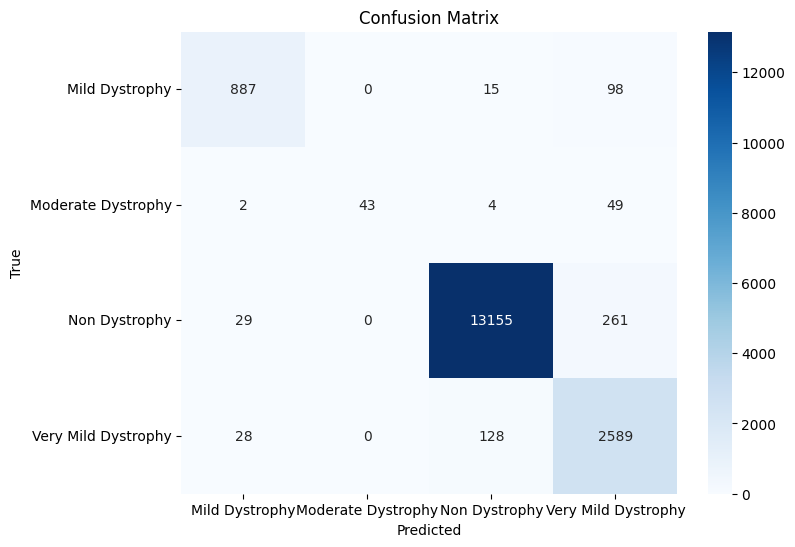

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define class labels (based on your dataset's labels)
classes = ['Mild Dystrophy', 'Moderate Dystrophy', 'Non Dystrophy', 'Very Mild Dystrophy']

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


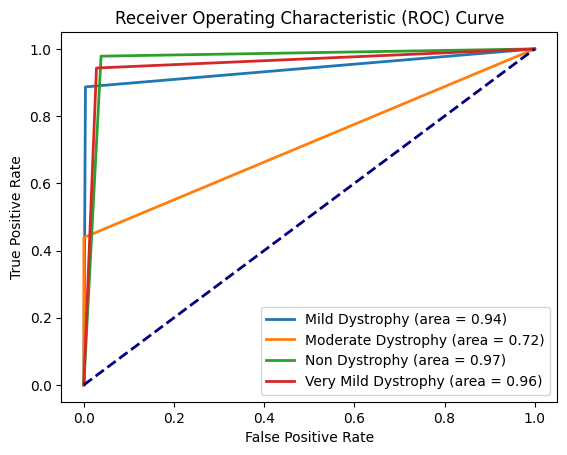

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Define class labels
classes = ['Mild Dystrophy', 'Moderate Dystrophy', 'Non Dystrophy', 'Very Mild Dystrophy']

# Binarize the true labels for multi-class ROC
true_labels_bin = label_binarize(true_labels, classes=[0, 1, 2, 3])  # Assuming 4 classes

# Calculate ROC curve for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(true_labels_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], np.array(predictions) == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(true_labels_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{classes[i]} (area = {roc_auc[i]:.2f})')

# Plot diagonal line (chance line)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(true_labels, predictions, average=None)  # Per class
recall = recall_score(true_labels, predictions, average=None)  # Per class
f1 = f1_score(true_labels, predictions, average=None)  # Per class

print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1 Score per class:", f1)

# Macro average (unweighted average of all classes)
print("Macro Precision:", precision_score(true_labels, predictions, average='macro'))
print("Macro Recall:", recall_score(true_labels, predictions, average='macro'))
print("Macro F1:", f1_score(true_labels, predictions, average='macro'))

# Weighted average (weighted by the support of each class)
print("Weighted Precision:", precision_score(true_labels, predictions, average='weighted'))
print("Weighted Recall:", recall_score(true_labels, predictions, average='weighted'))
print("Weighted F1:", f1_score(true_labels, predictions, average='weighted'))

Precision per class: [0.93763214 1.         0.98894903 0.86386386]
Recall per class: [0.887      0.43877551 0.97843064 0.9431694 ]
F1 Score per class: [0.91161357 0.60992908 0.98366172 0.90177638]
Macro Precision: 0.9476112573478592
Macro Recall: 0.8118438881182575
Macro F1: 0.8517451869775782
Weighted Precision: 0.9661822161577086
Weighted Recall: 0.9644840351689032
Weighted F1: 0.9643738202451066


In [ ]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(true_labels, predictions)
print(f"Matthews Correlation Coefficient: {mcc}")

Matthews Correlation Coefficient: 0.9046676288111032


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, predictions, target_names=classes))

                     precision    recall  f1-score   support

     Mild Dystrophy       0.94      0.89      0.91      1000
 Moderate Dystrophy       1.00      0.44      0.61        98
      Non Dystrophy       0.99      0.98      0.98     13445
Very Mild Dystrophy       0.86      0.94      0.90      2745

           accuracy                           0.96     17288
          macro avg       0.95      0.81      0.85     17288
       weighted avg       0.97      0.96      0.96     17288



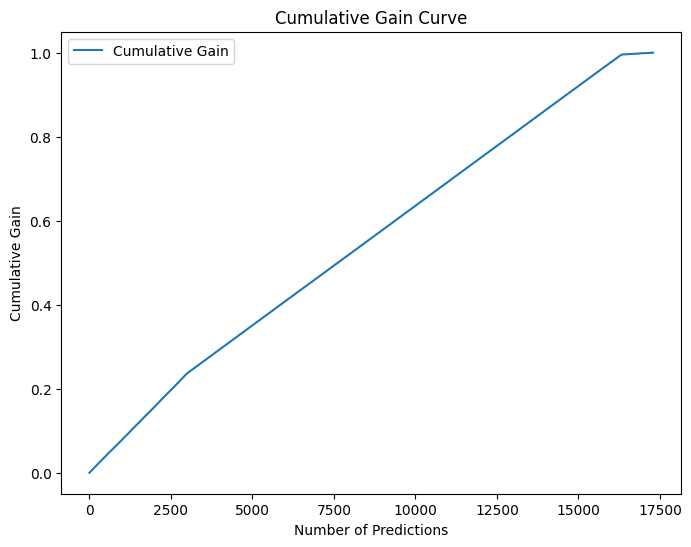

In [ ]:
def cumulative_gain(y_true, y_pred):
    sorted_idx = np.argsort(y_pred)[::-1]
    sorted_true = np.array(y_true)[sorted_idx]
    gain = np.cumsum(sorted_true) / np.sum(sorted_true)
    return gain

plt.figure(figsize=(8, 6))
gain = cumulative_gain(true_labels, predictions)
plt.plot(range(1, len(gain) + 1), gain, label='Cumulative Gain')
plt.xlabel('Number of Predictions')
plt.ylabel('Cumulative Gain')
plt.title('Cumulative Gain Curve')
plt.legend()
plt.show()

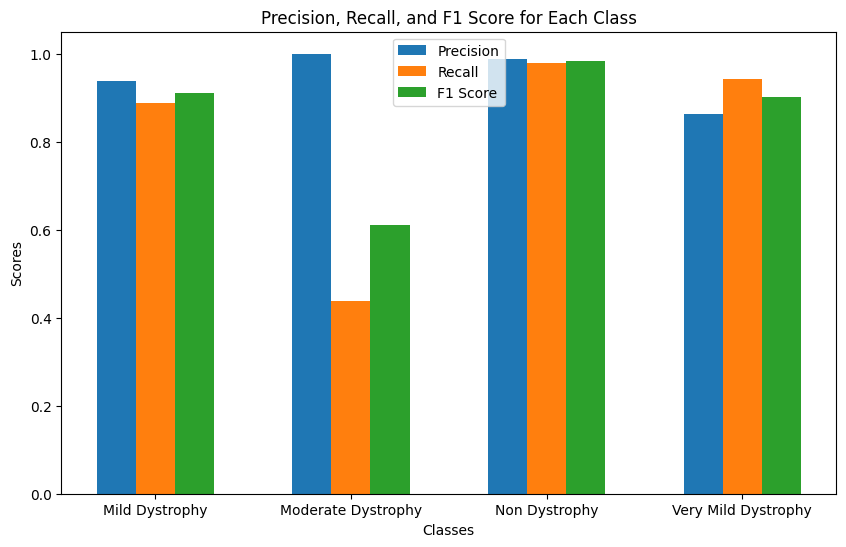

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

precision = precision_score(true_labels, predictions, average=None)
recall = recall_score(true_labels, predictions, average=None)
f1 = f1_score(true_labels, predictions, average=None)

width = 0.2
x = np.arange(len(classes))

plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Precision, Recall, and F1 Score for Each Class')
plt.xticks(x, classes)
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Accuracy of ResNet18: 66.60%
✅ Accuracy of ViT-CNN Hybrid: 97.58%
✅ Accuracy of Swin Transformer: 77.77%
✅ Accuracy of MedViT: 77.77%
✅ Accuracy of Ensemble: 83.78%


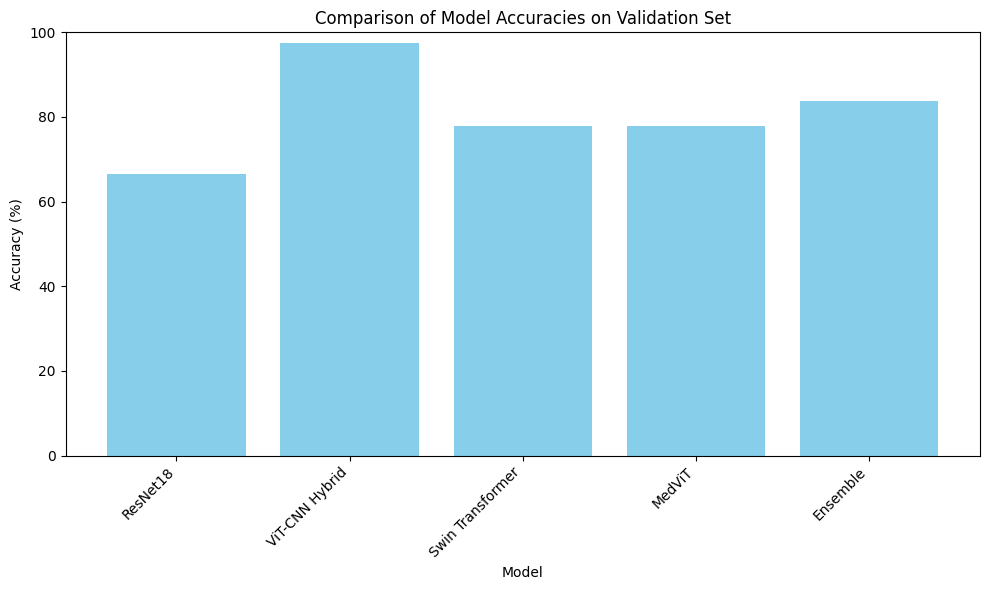

In [ ]:
import torch
from torchvision import models
import timm
import torch.nn as nn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the validation dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
val_dataset = MuscularDystrophyDataset(val_paths, val_labels, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32)

# --- Load Individual Models ---
# ResNet18
resnet_model = models.resnet18(pretrained=False)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 4)
resnet_model.load_state_dict(torch.load("resnet18_dystrophy_model.pth", map_location=device))
resnet_model.eval().to(device)

# ViT-CNN Hybrid
vit_model = ViT_CNN_Hybrid(num_classes=4)
vit_model.load_state_dict(torch.load("dyst_vit_cnn_hybrid.pth", map_location=device))
vit_model.eval().to(device)

# Swin Transformer
swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=4)
swin_model.load_state_dict(torch.load("dyst_swin_transformer.pth", map_location=device))
swin_model.eval().to(device)

# MedViT
medvit_model = MedViTNet(num_classes=4)
medvit_model.load_state_dict(torch.load("dyst_medvit_model.pth", map_location=device))
medvit_model.eval().to(device)

# Ensemble Model
ensemble_model = EnsembleModel([resnet_model, vit_model, swin_model, medvit_model])
ensemble_model.load_state_dict(torch.load('dyst_ensemble_model.pth', map_location=device))
ensemble_model.eval().to(device)

models_to_evaluate = {
    "ResNet18": resnet_model,
    "ViT-CNN Hybrid": vit_model,
    "Swin Transformer": swin_model,
    "MedViT": medvit_model,
    "Ensemble": ensemble_model
}

accuracies = {}

with torch.no_grad():
    for name, model in models_to_evaluate.items():
        correct = 0
        total = 0
        all_predicted = []
        all_labels = []
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        accuracy = 100 * correct / total
        accuracies[name] = accuracy
        print(f"✅ Accuracy of {name}: {accuracy:.2f}%")

# Plotting the accuracies
model_names = list(accuracies.keys())
accuracy_values = list(accuracies.values())

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_values, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracies on Validation Set')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()